 ![GM](./Graphical_Model.png)


$z_n$ sampling<br>
\begin{equation}\begin{aligned}z_n \sim P(z_n|z_{1:n-1,n+1:N}, x_{1:N}, \pi_{1:K}, \lambda_{1:K})=\frac{\prod_{k=1}^K[\pi_k\prod_{v=1}^V Poisson(x_{nv}|\lambda_{kv})]^{z_{nk}}}{\sum_{z_n}\prod_{k=1}^K[\pi_k\prod_{v=1}^V Poisson(x_{nv}|\lambda_{kv})]^{z_{nk}}}\end{aligned}\end{equation}

$\lambda_{kv}$ sampling<br>
\begin{equation}\begin{aligned}\lambda_{kv} \sim P(\lambda_{kv}|z_{1:N}, x_{1:N}, \pi_{1:k-1,k+1:K})=P(\lambda_{kv}|x_{1:N})\propto P(x_{1:N}|\lambda_{kv})P(\lambda_{kv})=Gamma(\alpha_{kv}+\beta)\end{aligned}\end{equation}$\alpha_{kv}$ : # of times word v is observed in cluster k

$\pi$ sampling<br>
\begin{equation}\begin{aligned}\pi\sim P(\pi|z_{1:N}, x_{1:N}, \lambda_{1:K})=P(\pi|z_{1:N}) \propto P(z_{1:N}|\pi)P(\pi)=Dirichlet(\alpha_1+N_1,...,\alpha_K+N_k)\end{aligned}\end{equation}

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import poisson, gamma, dirichlet, multinomial
from tqdm import tqdm

In [2]:
data = pd.DataFrame()
vocabs = []
with open('./vocab.txt', 'r') as f:
    for line in f:
        vocabs.append(line.split()[0])

rows = []
count = []
with open('./ap.dat', 'r') as f:
    for line in f:
        tmp = line.split(' ')
        count.append(tmp[0])
        tmp = tmp[1:]
        row = [0] * len(vocabs)
        for elem in tmp:
            index, value = elem.split(':')
            row[int(index)] = int(value)
        rows.append(row)
            
x_data = pd.DataFrame(rows, columns = vocabs)


In [26]:
def initialize_params(x_data, K, alpha, a, b):
    #topic_assignment: topics of articles
    #topic_word_counts: word count for each topic
    #topic_counts: article count for each topic
    N, V = x_data.shape
    topic_assignments = np.random.randint(0, K, size=N)
    topic_word_counts = np.zeros((K, V))
    topic_counts = np.zeros(K)
    lambdas = gamma.rvs(a, b, size=(K, V))
    pis = dirichlet.rvs(alpha * np.ones(K), size=N)
 

    for i in range(N):
        topic = topic_assignments[i]
        topic_counts[topic] += 1
        topic_word_counts[topic] += x_data[i]

    return topic_assignments, topic_word_counts, topic_counts, lambdas, pis

In [37]:
def gibbs_sampling(x_data, K, alpha, a, b, num_iters=1000):
    N, V = x_data.shape
    topic_assignments, topic_word_counts, topic_counts, lambdas, pis = initialize_params(x_data, K, alpha, a, b)

    log_probs = []
    for iteration in tqdm(range(num_iters)):
        for i in range(N):
            # Delete the topic count and topic word count for article i (exclude from sampling)
            current_topic = topic_assignments[i]
            topic_counts[current_topic] -= 1
            topic_word_counts[current_topic] -= x_data[i]
            
            # Compute the log likelihood
            log_topic_probs = np.zeros(K)
            for k in range(K):
                log_topic_word_prob = np.sum(poisson.logpmf(x_data[i], mu=lambdas[k]))
                log_topic_prior_prob = np.log(pis[i, k])
                log_topic_probs[k] = log_topic_word_prob + log_topic_prior_prob

            # Subtract the max log probability to avoid numerical instability
            log_topic_probs = log_topic_probs - np.max(log_topic_probs)
            topic_probs = np.exp(log_topic_probs)
            topic_probs /= topic_probs.sum()

            #print(log_topic_probs)
            # Sample new_topic from a multinomial distribution
            new_topic = np.random.choice(np.arange(K), p=topic_probs)

            # Add the topic count and topic word count for article i (update)
            topic_assignments[i] = new_topic
            topic_counts[new_topic] += 1
            topic_word_counts[new_topic] += x_data[i]

        for k in range(K):
            lambdas[k] = gamma.rvs(a + topic_word_counts[k], scale=1.0/(b + topic_counts[k]))
        pis = dirichlet.rvs(alpha + topic_counts, size=N)   

        if iteration % 20 ==0:  
        # compute and store the current log probability
            log_poisson = np.sum(poisson.logpmf(x_data, lambdas[topic_assignments]))
            log_dirichlet = np.sum(np.log(pis[np.arange(N), topic_assignments]))
            log_gamma = np.sum(gamma.logpdf(lambdas, a, scale=1.0/b))
            log_multinomial = np.sum(multinomial.logpmf(topic_counts, n=np.sum(topic_counts), p=pis))
            log_prob = log_poisson + log_dirichlet + log_gamma + log_multinomial
            log_probs.append(log_prob)

    return topic_assignments, topic_word_counts, topic_counts, lambdas, pis, log_probs

In [33]:
## Very Crude Pruning TODO Make this more reliable!

vocabs = []
with open('./vocab.txt', 'r') as f:
    for line in f:
        vocabs.append(line.strip())
        
len(vocabs)
del vocabs[8000:-1]
del vocabs[0:2000]
len(vocabs)
pruned_x = x_data[vocabs]

In [38]:

# Set parameters
K = 20  # Number of topics
alpha = 1.0  # Dirichlet prior parameter alpha
a = 1.0  # Gamma prior parameter a
b = 1.0 # Gamma prior parameter b
# num_iters = 100  # Number of iterations 
num_iters = 200 # Reduced Iterations 

### Take Pruned Value
# x_data_np = x_data.values
x_data_np = pruned_x.values


# Run the Gibbs sampler
print(x_data_np.shape)
topic_assignments, topic_word_counts, topic_counts, lambdas, pis, log_probs = gibbs_sampling(x_data_np, K, alpha, a, b, num_iters)


(2246, 6001)


100%|██████████| 200/200 [50:54<00:00, 15.27s/it]


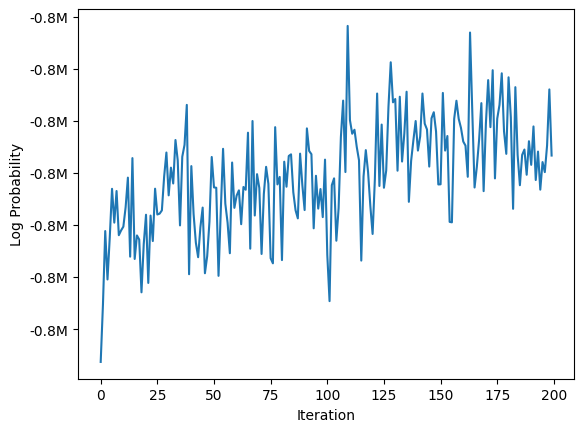

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# plot the log probabilities per iteration
fig, ax = plt.subplots()
ax.plot(log_probs)

# define the formatter for the y-axis
def millions(x, pos):
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

# apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Iteration')
plt.ylabel('Log Probability')
plt.show()

In [20]:
top_word_index = {}
for idx, ld in enumerate(lambdas):
    top_word_index[idx] =  sorted(range(len(ld)), key=lambda x: ld[x])[-30:]
    top_word_index[idx].reverse()

In [21]:
toplist = pd.DataFrame()

In [22]:
for topic in top_word_index:
    # print(f"Topic K={topic}:   ", )
    tmp =[]
    for idx in top_word_index[topic]:
        tmp.append(vocabs[idx])
    toplist[topic] = tmp

In [23]:
toplist

,0,1,2,3,4
0,smoke,dmass,governors,marion,undecided
1,presumed,antisemitism,grant,hindus,managing
2,radiation,approached,missouri,tribunal,relatively
3,thatchers,barrier,metal,expects,stealing
4,observed,informant,moderate,openness,hostile
5,boots,collapsing,dallas,legislators,certification
6,eec,weaponry,iowa,print,pool
7,sixth,stanford,broken,mechams,radar
8,solo,proud,douglas,proposing,magellan
9,burglary,journey,damages,barahona,bomber


In [24]:
vocabs

['providing',
 'administrations',
 'seats',
 'violated',
 'journalists',
 'looks',
 'cable',
 'sandinista',
 'brothers',
 'drove',
 'facing',
 'arizona',
 'flew',
 'monthly',
 'basic',
 'premier',
 'involvement',
 'poland',
 'aviation',
 'whites',
 'winning',
 'anderson',
 'kids',
 'encourage',
 'boost',
 'resignation',
 'prompted',
 'pictures',
 'obviously',
 'investigating',
 'extended',
 'express',
 'ensure',
 'alcohol',
 'degree',
 'transfer',
 'successful',
 'rival',
 'col',
 'goal',
 'overnight',
 'substantial',
 'partly',
 'route',
 'rescue',
 'affect',
 'practices',
 'matters',
 'putting',
 'path',
 'liberation',
 'va',
 'highly',
 'negative',
 'prove',
 'baghdad',
 'regular',
 'arguments',
 'sector',
 'alabama',
 'alan',
 'quake',
 'supports',
 'watching',
 'nicaraguan',
 'restructuring',
 'particular',
 'giant',
 'scale',
 'cutting',
 'negotiate',
 'declining',
 'germans',
 'runs',
 'discussions',
 'advertising',
 'grew',
 'pace',
 'grant',
 'dealing',
 'mondays',
 'founded',